## Импорт библиотек
Подключаем библиотеки для работы с данными, визуализации и предобработки признаков:
- pandas, numpy — чтение и обработка данных;
- matplotlib, seaborn — визуализация;
- StandardScaler — стандартизация признаков (нужна для корректного градиентного спуска и регуляризации).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


## Загрузка данных
Читаем обучающий и тестовый наборы данных из CSV и выводим первые строки для первичного знакомства со столбцами и типами данных.


## Первичная диагностика: пропуски и выбросы
- Считаем число пропусков по столбцам в train и test.
- Визуально проверяем выбросы по численным признакам (boxplot), чтобы понять масштаб и необходимость обработки.


In [2]:
train_df = pd.read_csv('../datasets/insurance_train.csv')
test_df = pd.read_csv('../datasets/insurance_test.csv')
print("Обучающий набор данных:")
display(train_df.head())

print("\nТестовый набор данных:")
display(test_df.head())

Обучающий набор данных:


,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200



Тестовый набор данных:


,age,sex,bmi,children,smoker,region,charges
0,61,male,38.380,0,no,northwest,12950.07120
1,59,female,34.800,2,no,southwest,36910.60803
2,31,male,30.875,0,no,northeast,3857.75925
3,24,female,33.345,0,no,northwest,2855.43755
4,31,male,28.500,5,no,northeast,6799.45800


## Обработка выбросов (IQR) по признаку BMI
Удаляем наблюдения, где BMI выходит за границы [Q1 − 1.5·IQR, Q3 + 1.5·IQR]. Это уменьшает влияние экстремальных значений на оценку коэффициентов.


Пропуски train:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски test:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


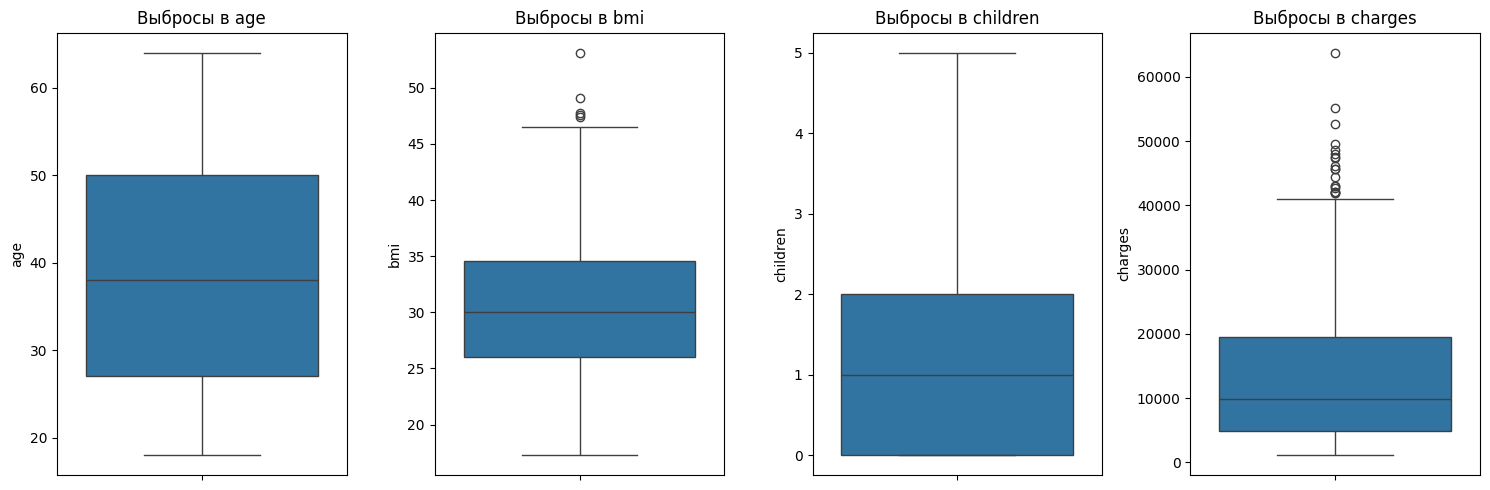

In [3]:
print("Пропуски train:")
print(train_df.isnull().sum())

print("\nПропуски test:")
print(test_df.isnull().sum())

numerical_features = ['age', 'bmi', 'children', 'charges']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=train_df[feature])
    plt.title(f'Выбросы в {feature}')
plt.tight_layout()
plt.show()

## Кодирование категориальных признаков и разбиение X/y
- One-Hot Encoding для `sex`, `smoker`, `region` (drop_first=True для избежания дамми-ловушки).
- Выделяем целевую переменную `charges` и матрицу признаков.
- Проверяем итоговые размеры train/test.


In [4]:
print(f"Исходный размер train: {train_df.shape}")
Q1 = train_df['bmi'].quantile(0.25)
Q3 = train_df['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
initial_rows = train_df.shape[0]
train_df = train_df[(train_df['bmi'] >= lower_bound) & (train_df['bmi'] <= upper_bound)]

print(f"Размер train_df после удаления выбросов: {train_df.shape}")
print(f"Удалено строк: {initial_rows - train_df.shape[0]}")


Исходный размер train: (338, 7)
Размер train_df после удаления выбросов: (333, 7)
Удалено строк: 5


## Корреляционный анализ
Строим матрицу корреляций признаков с целевой переменной `charges` и между собой — это помогает понять важность признаков и риск мультиколлинеарности.


In [5]:
train_df_processed = pd.get_dummies(train_df, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=float)
test_df_processed = pd.get_dummies(test_df, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=float)

train_labels = train_df_processed['charges']
test_labels = test_df_processed['charges']

train_df_processed = train_df_processed.drop('charges', axis=1)
test_df_processed = test_df_processed.drop('charges', axis=1)
print(f"Размер train: {train_df_processed.shape}")
print(f"Размер test:   {test_df_processed.shape}")
train_df_processed.head()

Размер train: (333, 8)
Размер test:   (1000, 8)


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,26,27.060,0,1.0,1.0,0.0,1.0,0.0
1,58,36.955,2,1.0,1.0,1.0,0.0,0.0
2,20,24.420,0,0.0,1.0,0.0,1.0,0.0
3,51,38.060,0,0.0,1.0,0.0,1.0,0.0
4,62,25.000,0,0.0,0.0,0.0,0.0,1.0


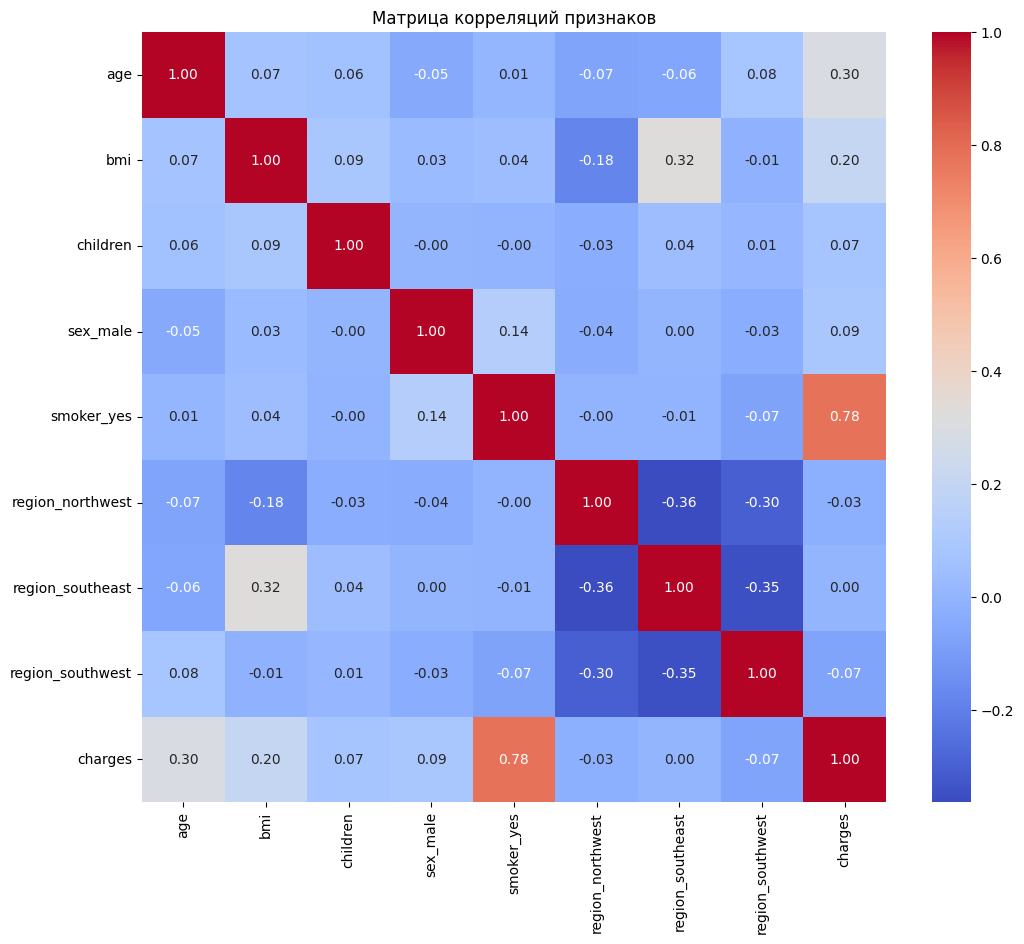

In [6]:
correlation_df = train_df_processed.copy()
correlation_df['charges'] = train_labels

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций признаков')
plt.show()

# 2

## Стандартизация и формирование матриц для регрессии
- Стандартизируем признаки (среднее=0, std=1), чтобы коэффициенты корректно обучались градиентными методами.
- Добавляем столбец из единиц (bias) к X.
- Разделяем на X (признаки) и y (цель) для train/test.


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df_processed)
X_test_scaled = scaler.transform(test_df_processed)
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]
y_train = train_labels.values
y_test = test_labels.values
print("Размер обучающей выборки (X):", X_train_b.shape)
print("Размер тестовой выборки (X):", X_test_b.shape)

Размер обучающей выборки (X): (333, 9)
Размер тестовой выборки (X): (1000, 9)


# Аналитически

## Линейная регрессия: аналитическое решение
Реализуем формулу нормальных уравнений: \(w^* = (X^TX)^{-1}X^Ty\). Это дает точное решение при обратимости \(X^TX\).


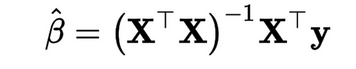

In [8]:
def analytical_solution(X, y):
    weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return weights
weights_analytical = analytical_solution(X_train_b, y_train)
print("Веса:")
print(weights_analytical)

Веса:
[13907.53661462  3444.2412296   2044.55137654   588.17924664
  -133.56701235  9582.89959443   -90.97616799  -629.93727462
  -658.23595162]


## Линейная регрессия: численно (градиентный спуск)
Итеративно минимизируем MSE:
- шаг по градиенту \(\nabla Q = \frac{1}{m}X^T(Xw - y)\);
- накапливаем историю ошибки для контроля сходимости.


# Численно

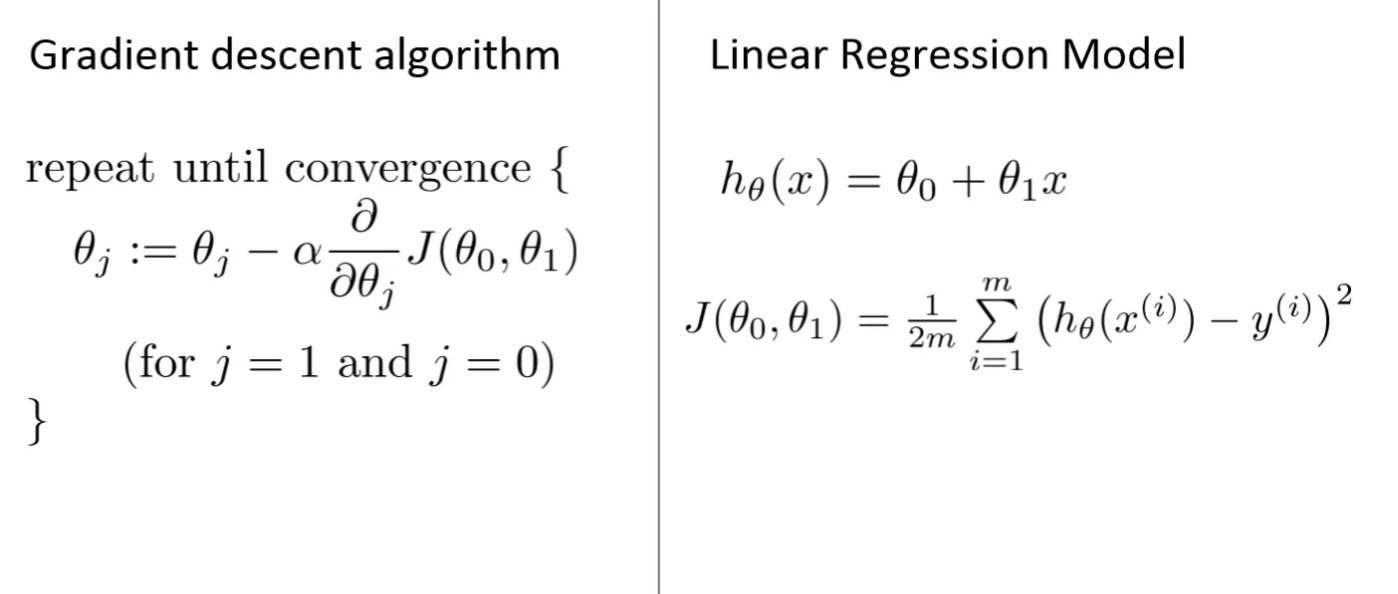

## Пункт 3. Регуляризация: зачем и что меняется
- Проблема: высокие, неустойчивые веса из‑за корреляций/шумов → переобучение.
- Идея: добавить штраф за величину весов (L2). Это сглаживает модель и улучшает обобщение.
- Что меняется:
  - в аналитике: \((X^TX + \lambda I)^{-1}X^Ty\);
  - в градиенте: добавляется член \(\lambda w\) (bias не штрафуем).
- Эффект: веса уменьшаются по модулю, дисперсия предсказаний снижается.


## Ridge (L2) регуляризация: аналитическое решение
Минимизируем \(||Xw-y||^2 + \lambda||w||_2^2\):
- решение: \(w^* = (X^TX + \lambda I)^{-1}X^Ty\);
- bias (первый коэффициент) не штрафуем — зануляем соответствующий элемент в \(I\).


## Ridge (L2) регуляризация: градиентный спуск
Оптимизируем ту же цель численно:
- градиент = \(\frac{1}{m}X^T(Xw-y) + \frac{\lambda}{m}w\);
- bias не регуляризуем (первый вес исключаем из штрафа);
- отслеживаем суммарную функцию потерь (MSE + L2).


## Пункт 4. Оценка обобщающей способности: зачем и как
- Зачем: понять, насколько модель работает на новых данных (не виденных при обучении).
- Как сравниваем:
  1) базовая константа (среднее по train);
  2) линейная регрессия (без регуляризации);
  3) Ridge (L2).
- Метрика: MSE на тесте (меньше — лучше). Визуализируем столбиками для наглядности.


Веса:
[13907.53658624  3444.28905318  2044.43409597   588.17492409
  -133.53193255  9582.94538707   -90.58401709  -629.47360291
  -657.83534732]


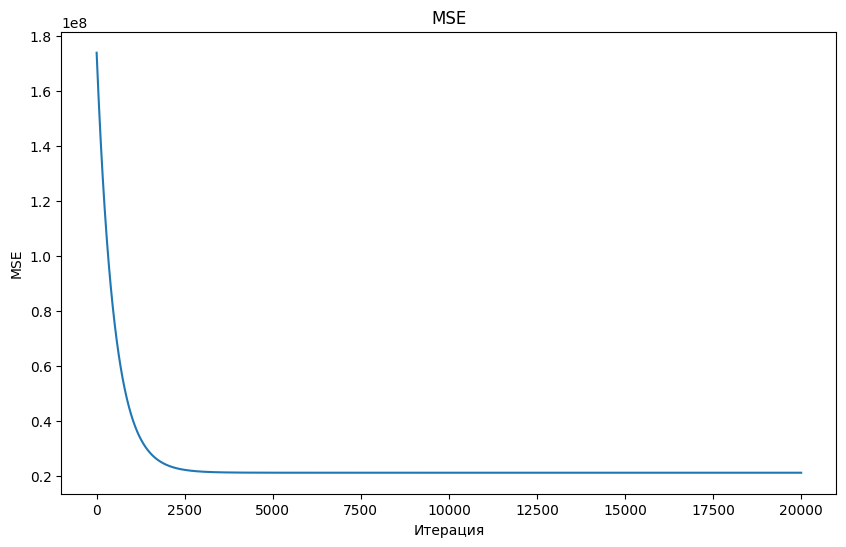

In [9]:
def gradient_descent(X, y, learning_rate, n_iterations):
    m, n = X.shape
    weights = np.zeros(n)
    cost_history = []
    for i in range(n_iterations):
        prediction = X.dot(weights)
        error = prediction - y
        gradient = (1/m) * X.T.dot(error)
        weights = weights - learning_rate * gradient
        
        cost = (1/(2*m)) * np.sum(error**2)
        cost_history.append(cost) 
    return weights, cost_history

learning_rate = 0.001
n_iterations = 20000
weights_gd, cost_history = gradient_descent(X_train_b, y_train, learning_rate, n_iterations)
print("Веса:")
print(weights_gd)
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), cost_history)
plt.title('MSE')
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.show()

## Оценка обобщающей способности на тесте
Сравниваем MSE на тестовой выборке для трёх моделей:
1) константная (среднее по train);
2) линейная регрессия;
3) Ridge (L2). Визуализируем результаты.


# 3 Регуляризация

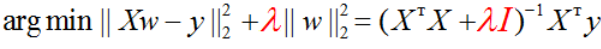

In [10]:
def analytical_ridge_solution(X, y, lambda_):
    m, n = X.shape
    I = np.identity(n)
    I[0, 0] = 0
    term_to_invert = X.T.dot(X) + lambda_ * I
    weights = np.linalg.inv(term_to_invert).dot(X.T).dot(y)
    return weights
l_lamb = 100
weights_ridge_analytical = analytical_ridge_solution(X_train_b, y_train, l_lamb)
print("Веса:")
print(weights_ridge_analytical)

Веса:
[13907.53661462  2700.48828015  1620.50851549   503.83630954
   116.30221013  7369.30664785   -60.10999637  -370.83412899
  -502.18173576]


Веса:
[13907.53658624  2700.48833918  1620.50837081   503.83630421
   116.30225349  7369.30670424   -60.1095127   -370.83355709
  -502.18124168]


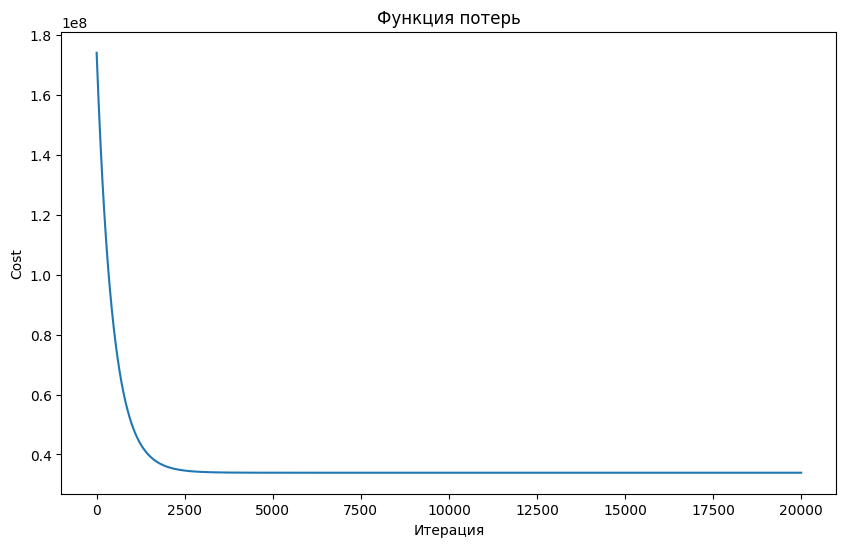

In [11]:
def grad_desc_l(X, y, learning_rate=0.01, n_iterations=1000, l_lamb=1.0):
    m, n = X.shape
    weights = np.zeros(n)
    cost_history = []
    for i in range(n_iterations):
        prediction = X.dot(weights)
        error = prediction - y
        gradient = (1/m) * X.T.dot(error)
        weights_for_reg = weights.copy()
        weights_for_reg[0] = 0
        gradient += (l_lamb/m) * weights_for_reg
        weights = weights - learning_rate * gradient
        mse_cost = (1/(2*m)) * np.sum(error**2)
        reg_cost = (l_lamb/(2*m)) * np.sum(weights_for_reg**2)
        total_cost = mse_cost + reg_cost
        cost_history.append(total_cost)
    return weights, cost_history

weights_ridge_gd, cost_history_ridge = grad_desc_l(X_train_b, y_train, learning_rate=learning_rate, n_iterations=n_iterations, l_lamb=l_lamb)
print("Веса:")
print(weights_ridge_gd)
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), cost_history_ridge)
plt.title('Функция потерь')
plt.xlabel('Итерация')
plt.ylabel('Cost')
plt.show()

# 4 

,Модель,MSE на тесте
0,Константная модель,1.414566e+08
1,Линейная рег,3.428862e+07
2,Регрессия L2,4.126150e+07


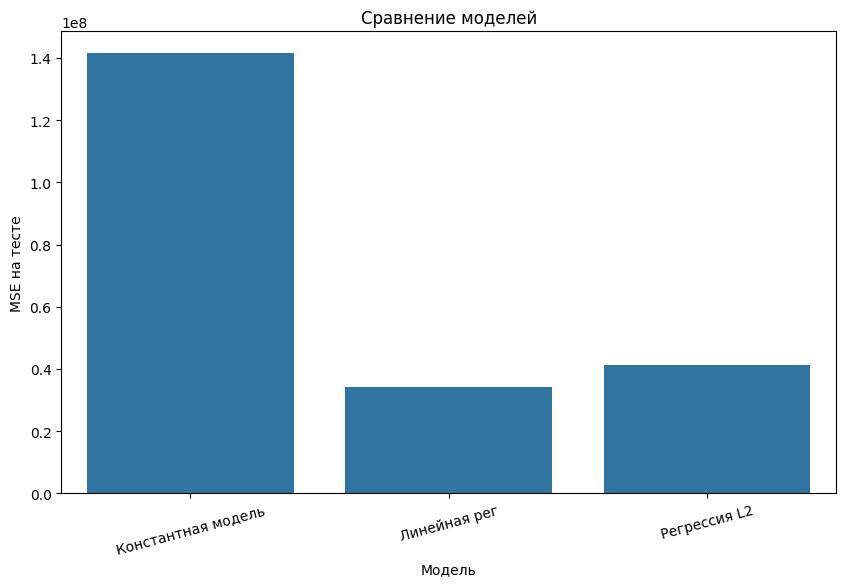

In [12]:

from sklearn.metrics import mean_squared_error
results = {}

mean_charge = y_train.mean()
y_pred_const = np.full_like(y_test, fill_value=mean_charge)
mse_const = mean_squared_error(y_test, y_pred_const)
results['Константная модель'] = mse_const

y_pred_linear = X_test_b.dot(weights_analytical)
mse_linear = mean_squared_error(y_test, y_pred_linear)
results['Линейная рег'] = mse_linear

y_pred_ridge = X_test_b.dot(weights_ridge_analytical)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
results['Регрессия L2'] = mse_ridge

results_df = pd.DataFrame(list(results.items()), columns=['Модель', 'MSE на тесте'])
display(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Модель', y='MSE на тесте', data=results_df)
plt.title('Сравнение моделей')
plt.xticks(rotation=15)
plt.show()
